# Email retention marketing evaluation

## Background: 
* The company's product is a travel agent website. 
* We are collaborating with the marketing team to increase the number of hotel orders booked through the company webste by encouraging return visits from users who have previously visited the site but did not make a purchase. 
* Previous user behavior analysis categorizes users based on their intent to book hotels for a recent trip. The marketing team launched an email campaign targeting the group of users with the highest booking intent but did not proceed to book a hotel through the site. We have been asked to evaluate the impact of what the marketing team have done and provide some insights on how to send emails to maximize the probability of users clicking on the link inside the email. The link leads to the search results page from the user's last session on the company's website.

#### Assumptions
* We assume each email link click is independent from each other.

## Strategy & Methodology
* **Project goal**: This project aims to evaluate the impact of marketing email characteristics and prioritize projects to improve the capaign with marketing team.
* **Target users**: The users from the group with the highest booking intent according to a previous clustering analysis based on user behavior. 
* **Business Strategy**: We want to evaluate the impact of email sending time, content length and other characteristics to each user. The marketing team chose a random sample of users and emailed them. The emails were not sent in the setting of controlled tests (A/B tests). That is, we are not at the stage of testing specific email campaign's impact yet. We are exploring potential email campaign ideas and forming hypothesis from the emails sent. Based on the result, we will explore the priority of email campaign ideas and how to personalize email campaigns for each user group.
* **Questions to answer**
    * Define the metric that we will use to evaluate and improve this email campagin
    * How the email was delivered?
    * How did the users interact with the email and the link inside? (Do they open the email? Do they click on the link)
    * Figure out what type of users are more interested in what type of email campaign. 
        * How to profile the types of users? (What features to use)
        * Which factors of designing / sending emails have more impact in general users and on the level of smaller user segments?

* **Data Science Methodology**: 
    * To define the metric, we will conduct a funnel analysis.
    * We will have an Exploratory Data Analysis to check how the emails were delivered and how did the users interact with the email.
    * We will analyze how did the factors of designing / sending emails impact users interaction.
        * Since we have a response variable clearly denoting whether a user clicked the link inside the email, we will choose supervised learning methods. 
            * Logistic regression

## Data
#### Data sources
* Email data: It contains information about the the design and how emails were sent. 
* Users data: It contains demographic data and consumer data from the user receiving the email. 
* Email opened table: The id of the emails that were opened
* Link clicked table: the id of the emails whose link inside was clicked


## Define the metrics
We need to decide how we are going to measure whether the emails are successful.
1. Overall business objective: Increase the number of hotel orders on our site by re-engaging users who did not complete their recent bookings.
2. Let's use a **email funnel analysis** to break the objective down:
    * The email was not delivered in the inbox (ended up in spam folder)
    * The email was delivered in the inbox: 
        * The user did not check inbox.
        * Users saw the email in the inboox:
            * Users saw the email title in the inbox but did not click on it
            * **Users opened the email**:
                * Users did not see the link
                    * User did not reach to the part where the link was shown
                    * User reached to the link but ignored the link
                * Users saw the link:
                    * Users did not click
                    * Users clicked
                        * Users clicked by accident
                        * **Users clicked and stayed on our website for at least 5 seconds.**
                            * Users abandoned website without booking a hotel
                            * **Users booked a hotel**
3. We can pick the most important steps in the above and define the final funnel.
    * Email delivered in the inbox
        * Email opened
            * User clicked the link and stayed on our website for at least 5 seconds
                * Made a hotel reservation 
4. However, not every step can be tracked by us accurately. 
    * For example, email opens are tracked using a tiny, transparent 1x1 pixel GIF image included in the email. The images are hosted by the email marketing platform we use. Each image has a unique URL so when a user opens an email, the platform registers the email as opened because the image is loaded. So, what could go wrong? Most email apps today block the display of images by default. Only when the sender is added to a "Safe Sender" list will the images load. This means that most of the email opens cannot be tracked.
    * Given this, we need to eliminate the steps that cannot be tracked by us from the funnel. Here is a refined funnel:
        * Email delivered in the inbox
            * User clicked the link and stayed on our website for at least 5 seconds
                * Made a hotel reservation 
5. Select metric for each step. If it's a key point, let's use a count metric. If it's between key points, let's use a rate or probability.
    * Number of emails delivered in the inbox
        * **Click-through-probability of the link**: the number of users clicked on the link and stayed on the page for at least 5 seconds divided by the number of users who received the email. Each email's link click will be counted once. This will be the **main metric** we try to **optimize**.
            * **Conversion rate**: the number of users clicked the link and placed at least one hotel order on the same day divided by the number of users clicked on the link. This will be the **guardrail metric** to ensure the optimization of the main metric is leading to a sustainable growth of the product.

### In this project, we:
* Analyze how to improve the `click-through-probability` of the link inside the email


# Table of content:
1. Read the data & train and test set splitting
    * 1.1 Read the data
    * 1.2 Train / test split
2. Data quality check and cleaning
    * 2.1 Outliers handling
    * 2.2 Missing data imputing
3. Descriptive Stats
4. Machine Learning
    * 4.1 Methodology - Logistic Regression
    * 4.2 Feature engineering
    * 4.3 Build Logistic Regression
    * 4.4 Model evaluation
    * 4.5 Model Diagnosis 
    * 4.6 Model interpretation
5. Product analytics

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [119]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
# import preprocessing from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import average_precision_score, auc, classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import re
from scipy import stats

## 1. Read the data & train and test set splitting

### 1.1 Read the data

1. **Email data**: It contains information about the emails sent, including user ID, email ID, length of the email (two versions. one is short, the other is long), whether the email is personalized (two versions. One with user's name in the incipit, the other without), the hour when emails were sent, the day of the week when emails were sent.
    * Email ID is the primary key
    * User ID is the foreign key
2. **Users data**: It contains demographic data and consumer data from the user receiving the email, including a user's country and how many hotel orders a user has booked using our company website.
    * User ID is the primary key
3. **Email opened table**: The id of the emails that were opened within 7 days after sent
    * Email ID is the primary key
4. **Link clicked table**: Within 7 days after sending the email, we record the IDs of those emails where the included link was clicked and the recipient interacted with the website by visiting at least one hotel booking page.
    * Email ID is the primary key

In [3]:
data_path = '/Users/bing/Documents/Data_Science/project_data/email_campaign/'

In [4]:
email_data = pd.read_csv(data_path + 'email_data.csv')
user_data = pd.read_csv(data_path + 'user_data.csv')
email_opened_table = pd.read_csv(data_path + 'email_opened_table.csv')
link_clicked_table = pd.read_csv(data_path + 'link_clicked_table.csv')

### 1.Email_data table
It contains information about the emails sent, including user ID, email ID, length of the email (two versions. one is short, the other is long), whether the email is personalized (two versions. One with user's name in the incipit, the other without), the hour when emails were sent, the day of the week when emails were sent.
* Email ID is the primary key
* User ID is the foreign key

In [5]:
email_data.head()

,email_id,email_text,email_version,hour,weekday,user_id
0,8,short_email,generic,9,Thursday,91420
1,33,long_email,personalized,6,Monday,89864
2,46,short_email,generic,14,Tuesday,88194
3,49,long_email,personalized,11,Thursday,2858
4,65,short_email,generic,8,Wednesday,40969


The remaining aspects of email design that not shown in `email_data` are the same for all the emails. E.g. All emails have the same title.

### 2. Users data
It contains demographic data and consumer data from the user receiving the email, including a user's country and how many times a user has purchased using our company marketplace.
* User ID is the primary key

In [6]:
user_data.tail()

,user_id,user_country,user_past_purchases
99945,90411,US,0
99946,84643,US,5
99947,22813,UK,0
99948,45002,FR,4
99949,26377,FR,0


### 3. Email opened table: The id of the emails that were opened within 7 days after sent
* Email ID is the primary key

In [7]:
email_opened_table.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


### 4. Link clicked table: Within 7 days after the email sent, we record the id of the emails whose link inside was clicked and stayed for at least 5 seconds
* Email ID is the primary key

In [8]:
link_clicked_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


We want to join the four tables so we have information for how each email was sent, who was the email recipient and how did they interact with the email.

#### Let's check how we record the emails opens and link clicks.

In [9]:
if email_data['email_id'].nunique() == email_data['user_id'].nunique():
    print('We sent one email to each user.')

We sent one email to each user.


In [10]:
if email_opened_table['email_id'].nunique() == email_opened_table.shape[0]:
    print("We do not record repeated opening of an email.")

We do not record repeated opening of an email.


In [11]:
if link_clicked_table['email_id'].nunique() == link_clicked_table.shape[0]:
    print("We do not record repeated clicks of a link.")

We do not record repeated clicks of a link.


### Good, since email_opened_table and link_clicked_table only contains unique email ids, we can `out join` them on email id
Using `out join` we can keep all the emails from all three tables, which enables missing values investigation later.

In [12]:
#create extra column to label emails sent, opened, and clicked
email_data['sent'] = 1
email_opened_table['opened'] = 1
link_clicked_table['clicked'] = 1
email_df = pd.merge(left = email_data, right = email_opened_table, how = 'outer', on = 'email_id')
email_df = pd.merge(left = email_df, right = link_clicked_table, how = 'outer', on = 'email_id')

In [13]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_id,sent,opened,clicked
0,8,short_email,generic,9.0,Thursday,91420.0,1.0,NaN,NaN
1,33,long_email,personalized,6.0,Monday,89864.0,1.0,NaN,NaN
2,46,short_email,generic,14.0,Tuesday,88194.0,1.0,NaN,NaN
3,49,long_email,personalized,11.0,Thursday,2858.0,1.0,1.0,NaN
4,65,short_email,generic,8.0,Wednesday,40969.0,1.0,NaN,NaN


#### Let's check if the email sending funnel make sense 
1. If the link inside an emails is clicked, then the email should be opened. 
2. If an email is opened, then it should be recorded in the emails sent. 

In [14]:
email_df.loc[ (email_df['clicked'] == 1) & (pd.isnull(email_df['opened'])) ]

,email_id,email_text,email_version,hour,weekday,user_id,sent,opened,clicked
99950,9912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99951,858449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99952,505169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99953,846127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99954,763513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99955,503034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99956,841517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99957,327248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99958,645444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
99959,647421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### We have some emails with link clicked but was not recorded as opened!  This does not make sense.  We need to check with the engineer about data recording.  For now, let's remove them.

In [15]:
email_df.drop(email_df.loc[ (email_df['clicked'] == 1) & (pd.isnull(email_df['opened'])) ].index, inplace=True)

In [16]:
if email_df.loc[ (email_df['clicked'] == 1) & (pd.isnull(email_df['sent'])) ].shape[0] == 0:
    print("Now, all the emails clicked are recorded in email sent table.")

Now, all the emails clicked are recorded in email sent table.


In [17]:
if email_df.loc[ (email_df['opened'] == 1) & (pd.isnull(email_df['sent'])) ].shape[0] == 0:
    print("All the emails opened are recorded in the emails sent table.")

All the emails opened are recorded in the emails sent table.


#### Now we can say that all the null values in `opened` and `clicked` means the user did not open the email or did not click on the link. Let's assign them to 0.

In [18]:
email_df['opened'] = email_df['opened'].fillna(value=0)
email_df['clicked'] = email_df['clicked'].fillna(value=0)

### Let's join the email_df and user_data

In [19]:
email_merge_df = pd.merge(left=email_df, right=user_data, how = 'left', on ='user_id')

In [20]:
print("The dimensions of the data set are:", email_merge_df.shape[0], "observations and", email_merge_df.shape[1], "variables." )

The dimensions of the data set are: 99950 observations and 11 variables.


In [21]:
email_merge_df.head()

,email_id,email_text,email_version,hour,weekday,user_id,sent,opened,clicked,user_country,user_past_purchases
0,8,short_email,generic,9.0,Thursday,91420.0,1.0,0.0,0.0,US,3
1,33,long_email,personalized,6.0,Monday,89864.0,1.0,0.0,0.0,US,0
2,46,short_email,generic,14.0,Tuesday,88194.0,1.0,0.0,0.0,US,3
3,49,long_email,personalized,11.0,Thursday,2858.0,1.0,1.0,0.0,US,10
4,65,short_email,generic,8.0,Wednesday,40969.0,1.0,0.0,0.0,UK,3


Each row represents a distinct email.
The columns (in order) are:

* **email_id**: Unique id for each email
* **email_text**: there are two different versions of the emails sent, short_email and long_email.
* **email_version**: personalized emails have the name of the person receiving the email. generic emails have generic greeting.
* **hour**: the local time on which the email was sent
* **weekday**: the weekday on which the email was sent
* **user_id**: Unique id for each user
* **sent**: whether the email is sent by us.
* **opened**: whether the user has opened the email.
* **clicked**: whether the user has clicked on the link inside the email.
* **user_country**: the country where the person receiving the mail is based. It comes from the user ip address when they registered the account.
* **user_past_purchases**: how many times the user has booked hotels from the website after registration

In [22]:
# Check the data types of the variables
email_merge_df.dtypes

email_id                 int64
email_text              object
email_version           object
hour                   float64
weekday                 object
user_id                float64
sent                   float64
opened                 float64
clicked                float64
user_country            object
user_past_purchases      int64
dtype: object

In [23]:
# Convert 'email_text', 'email_version', 'weekday', 'user_country' to categorical variable
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    email_merge_df[col] = email_merge_df[col].astype('category')


In [24]:
email_merge_df.dtypes

email_id                  int64
email_text             category
email_version          category
hour                    float64
weekday                category
user_id                 float64
sent                    float64
opened                  float64
clicked                 float64
user_country           category
user_past_purchases       int64
dtype: object

#### Now, the types of variables are correct.

## 1.2 Train / test split
In this project, we want to analyze how to improve the `click-through-probability` of the link inside the email. 

First, let's split the entire dataset into a training set and a testing set according to the target variable. Then, we'll explore the data and determine how to preprocess it using the training set. Finally, we'll apply the same data preprocessing methods to the test set that we used on the training set.

In [25]:
email_merge_df.head()

,email_id,email_text,email_version,hour,weekday,user_id,sent,opened,clicked,user_country,user_past_purchases
0,8,short_email,generic,9.0,Thursday,91420.0,1.0,0.0,0.0,US,3
1,33,long_email,personalized,6.0,Monday,89864.0,1.0,0.0,0.0,US,0
2,46,short_email,generic,14.0,Tuesday,88194.0,1.0,0.0,0.0,US,3
3,49,long_email,personalized,11.0,Thursday,2858.0,1.0,1.0,0.0,US,10
4,65,short_email,generic,8.0,Wednesday,40969.0,1.0,0.0,0.0,UK,3


* The target variable is `clicked`, we keep all the features of email design / email sending strategy because they are all prior to users clicking on the link. Therefore, they might have influence on whether users click on the link.

* We remove the vairable `sent` and `opend` because all the emails with link clicked are labled sent and opened.

In [26]:
email_merge_df.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday', 'user_id',
       'sent', 'opened', 'clicked', 'user_country', 'user_past_purchases'],
      dtype='object')

In [27]:
email_merge_df = email_merge_df[['email_id', 'email_text', 'email_version', 
                                       'hour', 'weekday', 'user_id',
                                      'user_country', 'user_past_purchases', 'clicked']]

#### The target variable `clicked` has two values, 0 and 1.
- It is a binary variable, which means we are dealing with a classification problem. 
- When split the data set into training and testing set, it is important to make sure the two sets have the same ratios of 1 and 0. 
    - Use `Sklearn`'s `stratified split`
- Since emails are sent in a sequence and might be stored in the same sequence, we need to shuffle the records when splitting them into training / testing set.
    - Use `Sklearn`'s `shuffle` feature

In [28]:
target = 'clicked'
target

'clicked'

In [29]:
features = list(email_merge_df.columns)
features.remove(target)
features

['email_id',
 'email_text',
 'email_version',
 'hour',
 'weekday',
 'user_id',
 'user_country',
 'user_past_purchases']

In [30]:
X = email_merge_df[features]
y = email_merge_df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, 
                                                    stratify = y,  shuffle=True )

In [31]:
#Check Percentage of clicked emails in Train and Test Set
percentage_clicked_training = 100*y_train.sum()/len(y_train)
percentage_clicked_testing  = 100*y_test.sum()/len(y_test)
                                                  
print("Percentage of Clicked emails in the training set: {:0.2f}%.".format(percentage_clicked_training))
print("Percentage of Clicked emails in the testing set: {:0.2f}%.".format(percentage_clicked_testing))

Percentage of Clicked emails in the training set: 2.07%.
Percentage of Clicked emails in the testing set: 2.07%.


In [34]:
# Create a new dataframe with the training data 
train_df = X_train.join(y_train)

We split the training and testing set evenly regarding the ratio of clicked emails! 
* The ratio of clicked emails is very low. We have a problem with **unbalanced data**. Let's deal with this problem after feature engineering.
* Now we know that around 2.07% of the users that received the emails clicked on the link inside.

### Take a look at types of independent variables
All the independent variables have potential influence to the dependent variables. Some vairables that are manipulated by us and some variables are extra factor but not modifiable by an experiment. Let's categorize the variables so we have a better idea how to explore them:

* Manipulatable variables:
    * **email_id**: Unique id for each email
    * **email_version**: personalized emails have the name of the person receiving the email. generic emails have generic greeting.
    * **hour**: the local time on which the email was sent
    * **weekday**: the weekday on which the email was sent

* Extra factors:
    * Participant variables:
        * **user_id**: Unique id for each user
        * **user_country**: the country where the person receiving the mail is based. It comes from the user ip address when they registered the account.
        * **user_past_purchases**: how many times the user has purchased from the website after registration


## 2. Data preprocessing and exploratory data analysis.

We explore the training set only to avoid data leakage, that is the hold-out test set leaks into the dataset used to train the model. 
* If there is data transformation, we fit the tranformation model on training set and apply it to both training and test set. 
* For outliers handling, we only remove outliers from the training set. The test set remains the same.

### 2.1. Outliers Checking and handling
This part is done on training set only, not applicable for testing set.

In [35]:
X_train.head()

,email_id,email_text,email_version,hour,weekday,user_id,user_country,user_past_purchases
85425,854505,long_email,generic,8.0,Tuesday,27502.0,US,3
73628,736085,short_email,generic,2.0,Friday,17686.0,FR,8
92205,922368,short_email,personalized,4.0,Thursday,84276.0,US,0
47277,471597,long_email,generic,11.0,Tuesday,61092.0,ES,1
95455,955189,long_email,personalized,6.0,Saturday,15309.0,ES,13


In [36]:
X_train.describe(include='all')

,email_id,email_text,email_version,hour,weekday,user_id,user_country,user_past_purchases
count,69965.000000,69965,69965,69965.000000,69965,69965.000000,69965,69965.000000
unique,NaN,2,2,NaN,7,NaN,4,NaN
top,NaN,long_email,generic,NaN,Saturday,NaN,US,NaN
freq,NaN,35271,35176,NaN,10142,NaN,42038,NaN
mean,498641.205560,NaN,NaN,9.055714,NaN,49880.577289,NaN,3.872336
std,288529.299802,NaN,NaN,4.440548,NaN,28838.533290,NaN,3.196470
min,8.000000,NaN,NaN,1.000000,NaN,0.000000,NaN,0.000000
25%,248854.000000,NaN,NaN,6.000000,NaN,24914.000000,NaN,1.000000
50%,497558.000000,NaN,NaN,9.000000,NaN,49807.000000,NaN,3.000000
75%,748455.000000,NaN,NaN,12.000000,NaN,74854.000000,NaN,6.000000


#### Outliers checklist:
- Numerical variables
    1. Some numerical variables should only have positive values:
        - hour, user_past_purchases are all positive
    2. Is there any variable with extreme values?
        - hour: It does not seem to follow a uniform distribution. Assume following normal distribution, judge by the mean and +- 2 * standard deviation, the max hour of 24 seems fall out of the 95% range. Needs to be invesitgated.
        - User_past_purchases: Assume following normal distribution. Judge by the mean and +- 2 * standard deviation, it seems the data distribution is right skewed, with extreme values. Needs to be investigated.
- Categorical variables
    1. Does the number of levels of each variable make sense?
        - email_version, weekday, user_country all seem to have reasonable number of levels.
    2. Does the distribution of levels of each variable seem right?
        - Needs to be verified.


#### Investigate outliers of numerical variables: `hour`, `User_past_purchases` 

Text(0, 0.5, 'Normalized frequencies')

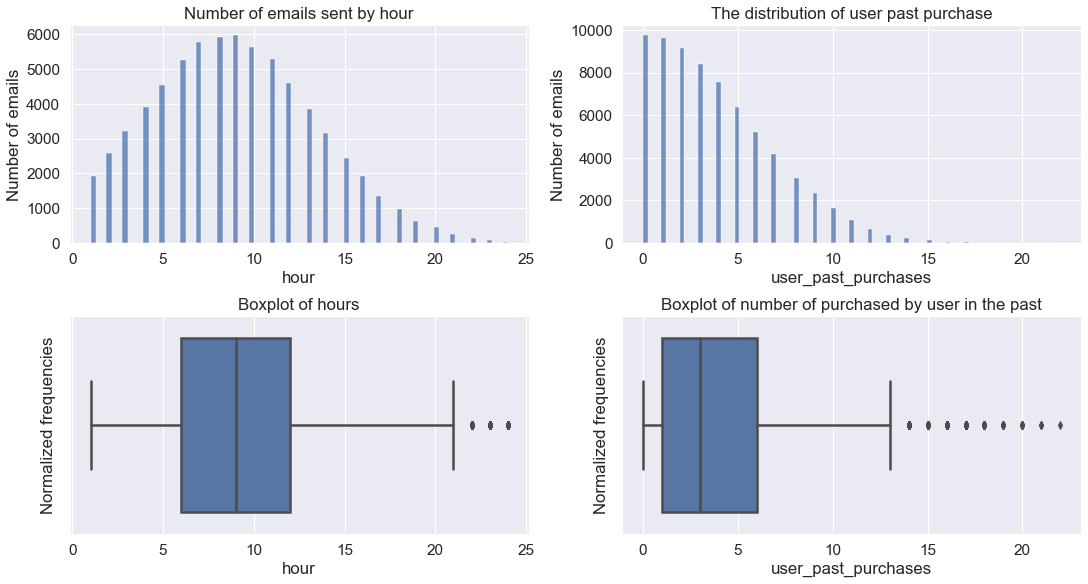

In [37]:
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8),constrained_layout = True)
ax = ax.ravel()

sns.histplot(x ='hour', data = X_train, ax=ax[0])
ax[0].set_title('Number of emails sent by hour')
ax[0].set_ylabel('Number of emails')

sns.histplot(x ='user_past_purchases', data = X_train, ax=ax[1])
ax[1].set_title('The distribution of user past purchase')
ax[1].set_ylabel('Number of emails')

sns.boxplot(x ='hour', data = X_train, ax=ax[2])
ax[2].set_title('Boxplot of hours')
ax[2].set_ylabel('Normalized frequencies')

sns.boxplot(x ='user_past_purchases', data = X_train, ax=ax[3])
ax[3].set_title('Boxplot of number of purchased by user in the past')
ax[3].set_ylabel('Normalized frequencies')

In [38]:
pd.DataFrame({'hour': X_train['hour'].describe(), 'user_past_purchases': X_train['user_past_purchases'].describe() })

,hour,user_past_purchases
count,69965.000000,69965.000000
mean,9.055714,3.872336
std,4.440548,3.196470
min,1.000000,0.000000
25%,6.000000,1.000000
50%,9.000000,3.000000
75%,12.000000,6.000000
max,24.000000,22.000000


#### Numerical variables
* For `hour`: 
    * The number of emails sent after 21:00 is really low. These emails do not give us a reliable insight and might be recorded incorrectly in the database because of bugs. Let's remove them.
    * The hour variables seem to follow a right skewed normal distribution, which means the hour when the emails are sent is not randomized (If it's randomized, it should follow a uniform distribution).
* For `user_past_purchases`: 
    * It's rare to see a user with more than 13 purchases in the past. Those users can be power users that have very high consumption from our platform, so they can be very valuable information. If we want to focus on these users, we should keep them and use models that easily influenced by outliers.
        * After discuss with Project Manager, we decide to focus on marketing for average users, so we will remove outliers for models that easily influenced by outliers.

### Outliers handling: Create an outlier free training set:

In [39]:
# Create a function to remove outliers in a column of a dataframe using IQR
def remove_outlier(df, column):
    df_copy = df.copy()
    Q1 = df_copy[column].quantile(0.25)
    Q3 = df_copy[column].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    return df_copy[(df_copy[column] > Lower_Fence) & (df_copy[column] < Upper_Fence)]

In [40]:
clean_train_df = remove_outlier(train_df, 'hour')

In [41]:
clean_train_df = remove_outlier(clean_train_df, 'user_past_purchases')

#### Recreate the X_train and X_test with the cleanned dataframe

In [42]:
X_train = clean_train_df[features]
y_train = clean_train_df[[target]]

In [43]:
X_train.describe()

,email_id,hour,user_id,user_past_purchases
count,68888.000000,68888.000000,68888.000000,68888.000000
mean,498643.149765,8.954927,49883.911857,3.783707
std,288506.086296,4.310783,28841.188855,3.042542
min,8.000000,1.000000,0.000000,0.000000
25%,248770.500000,6.000000,24907.750000,1.000000
50%,497616.500000,9.000000,49826.500000,3.000000
75%,748354.750000,12.000000,74852.500000,6.000000
max,999998.000000,20.000000,99947.000000,13.000000


#### `user_past_purchases` and `hour`'s outliers are removed!

### Investigate the distribution of categorical variables
* Let's first check the distribution of each categorical variable over the entire training set. 

In [44]:
X_train.head()

,email_id,email_text,email_version,hour,weekday,user_id,user_country,user_past_purchases
85425,854505,long_email,generic,8.0,Tuesday,27502.0,US,3
73628,736085,short_email,generic,2.0,Friday,17686.0,FR,8
92205,922368,short_email,personalized,4.0,Thursday,84276.0,US,0
47277,471597,long_email,generic,11.0,Tuesday,61092.0,ES,1
95455,955189,long_email,personalized,6.0,Saturday,15309.0,ES,13


Text(0.5, 1.0, 'Number of emails sent by day of the week')

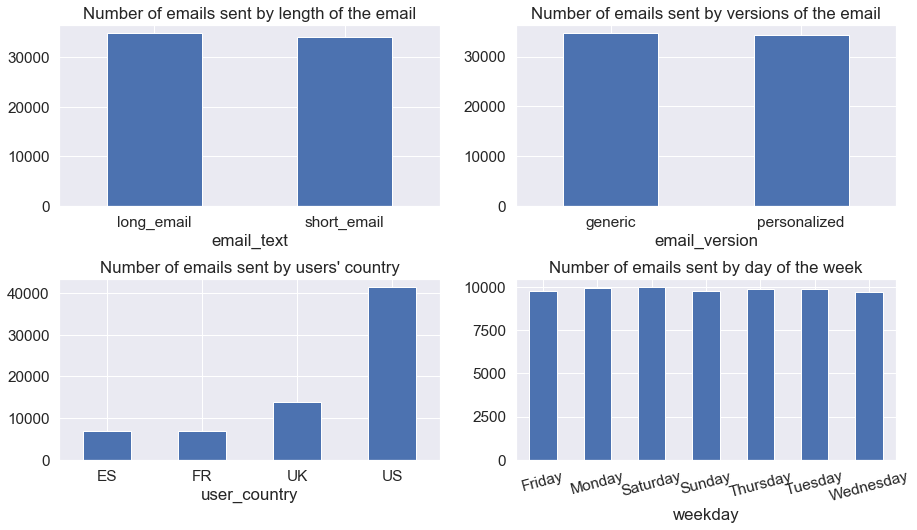

In [45]:
sns.set_context("notebook", font_scale=1.4)
plt.figure(1,figsize=(15, 8) )
plt.subplots_adjust(hspace=0.4)

plt.subplot(2,2,1)
X_train.groupby(['email_text']).size().plot.bar()
plt.xticks(rotation = 0)
plt.title("Number of emails sent by length of the email")

plt.subplot(2,2,2)
X_train.groupby(['email_version']).size().plot.bar()
plt.xticks(rotation = 0)
plt.title("Number of emails sent by versions of the email")

plt.subplot(2,2,3)
X_train.groupby(['user_country']).size().plot.bar()
plt.xticks(rotation = 0)
plt.title("Number of emails sent by users' country")

plt.subplot(2,2,4)
X_train.groupby(['weekday']).size().plot.bar()
plt.xticks(rotation = 15)

plt.title("Number of emails sent by day of the week")

#### The overall distribution of categorical variables
- Two lengths of emails distributed roughly evenly
- Two versions of personalized greetings distributed roughly evenly.
- The emails are sent out evenly on every week days
- The campaign has sent more emails to customers in US. Since the users are randomly selected, this mean the website's main customers come from the US, and it has a large British user base as well.
    * The distribution of `user_country` is not even. This rises a red flag of **multicollinearity**. We need to check whether the features are highly related with each other. In order to have meaningful insight for each variable, the variables need to be independent from each other, which means how a user receives a email should be randomized with all the options. That is, users from each country should have the same chance receiving certain email at certain time. e.g. We should not send all the users in the US with a personalized short email in the morning.


### Before we check multicolinearity of the features, we need to deal with missing data and feature engineering so we can explore the data set better.

> ### 2.2 Missing data

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68888 entries, 85425 to 68104
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   email_id             68888 non-null  int64   
 1   email_text           68888 non-null  category
 2   email_version        68888 non-null  category
 3   hour                 68888 non-null  float64 
 4   weekday              68888 non-null  category
 5   user_id              68888 non-null  float64 
 6   user_country         68888 non-null  category
 7   user_past_purchases  68888 non-null  int64   
dtypes: category(4), float64(2), int64(2)
memory usage: 2.9 MB


In [47]:
X_train.describe(include='all')

,email_id,email_text,email_version,hour,weekday,user_id,user_country,user_past_purchases
count,68888.000000,68888,68888,68888.000000,68888,68888.000000,68888,68888.000000
unique,NaN,2,2,NaN,7,NaN,4,NaN
top,NaN,long_email,generic,NaN,Saturday,NaN,US,NaN
freq,NaN,34748,34627,NaN,9976,NaN,41404,NaN
mean,498643.149765,NaN,NaN,8.954927,NaN,49883.911857,NaN,3.783707
std,288506.086296,NaN,NaN,4.310783,NaN,28841.188855,NaN,3.042542
min,8.000000,NaN,NaN,1.000000,NaN,0.000000,NaN,0.000000
25%,248770.500000,NaN,NaN,6.000000,NaN,24907.750000,NaN,1.000000
50%,497616.500000,NaN,NaN,9.000000,NaN,49826.500000,NaN,3.000000
75%,748354.750000,NaN,NaN,12.000000,NaN,74852.500000,NaN,6.000000


In [55]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29985 entries, 29056 to 30065
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   email_id             29985 non-null  int64   
 1   email_text           29985 non-null  category
 2   email_version        29985 non-null  category
 3   hour                 29985 non-null  float64 
 4   weekday              29985 non-null  category
 5   user_id              29985 non-null  float64 
 6   user_country         29985 non-null  category
 7   user_past_purchases  29985 non-null  int64   
dtypes: category(4), float64(2), int64(2)
memory usage: 1.3 MB


For the indepdent variables in the training and testing set:

Numerical variables:
* There are no null data.
Categorical variables:
* There are no null data. Every categorical variable has the correct number of unique levels.


In [56]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68888 entries, 85425 to 68104
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   clicked  68888 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [49]:
y_train.describe()

,clicked
count,68888.000000
mean,0.020047
std,0.140162
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [54]:
pd.DataFrame(y_test).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29985 entries, 29056 to 30065
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   clicked  29985 non-null  float64
dtypes: float64(1)
memory usage: 468.5 KB


For the response data in the training set:
* There is no null data. The range of the data is correct.

Thus, there are no missing data in the training and testing set.

> ### 2.3 Feature engineering
1. Binning continuous numerical variables: 
    * `hour` will be binned into 3 groups (morning, afternoon, night)
        * Usually time has a non-linear relationship with the target variables. This will be helpful for linear models.
    * `user_past_purchase` will be binned according to its quantiles
        * This is for making exploring the data easier.
        * Many models can create their own bins of numerical variables, e.g. decision trees, so let's keep the original variable in the dataframe as well.
2. Encode the categorical variables using one hot encoding.

### 2.3 (1) Binning numerical variable
Here we bin the numerical variables but also keep the original variables in the dataframe

In [57]:
# We are going to bin non-linear variables, such as hour

def binning(df):
    # We create bins from the train set
    # We will use the same bins for both train and test set
    df_copy = df.copy()
    #Bin the variables
    # bins_value = [0] + [np.quantile(df_train['user_past_purchases'], 0 + x*0.2) for x in range(6) if x>0]
    # bins_tag = []
    # for i in range(len(bins_value)):
    #     if i == 0:
    #         bins_tag.append('[%d,%d)'%(bins_value[i], bins_value[i+1]))
    #     if (i > 1) and (i<len(bins_value)-1):
    #         bins_tag.append('[%d,%d)'%(bins_value[i-1], bins_value[i]))
    #     if i == len(bins_value)-1:
    #         bins_tag.append('[%d,%d]'%(bins_value[i-1], bins_value[i]))
    # df_copy['user_past_purchases_binned'] = pd.cut(df_copy['user_past_purchases'], bins=bins_value, include_lowest=True, labels=bins_tag)
    
    #Hour
    df_copy['hour_binned'] = pd.cut(df_copy['hour'], bins=[1,5, 13, 21, 24], include_lowest=True, labels=['night', 'morning', 'afternoon', 'night2'])
    #replace night2 with night
    df_copy['hour_binned'] = df_copy['hour_binned'].replace('night2', 'night').cat.remove_unused_categories()
    return df_copy

In [58]:
#Process X_train
#Bin the variables accoding to the rules described above
X_train = binning(X_train)

In [59]:
X_train.head()

,email_id,email_text,email_version,hour,weekday,user_id,user_country,user_past_purchases,hour_binned
85425,854505,long_email,generic,8.0,Tuesday,27502.0,US,3,morning
73628,736085,short_email,generic,2.0,Friday,17686.0,FR,8,night
92205,922368,short_email,personalized,4.0,Thursday,84276.0,US,0,night
47277,471597,long_email,generic,11.0,Tuesday,61092.0,ES,1,morning
95455,955189,long_email,personalized,6.0,Saturday,15309.0,ES,13,morning


In [60]:
# Process X_test using the same bins as X_train
# Bin the variables accoding to the rules described above 
X_test = binning(X_test)

### 2.3 (2) Encode categorical variables. 
* Encode categorical variables via one hot encoding (dummy variables have value 0s and 1s)


In [64]:
def cate_encoding(df, drop_first):
    df_copy = df.copy()
    #Before building the regression, we need to know which ones are the reference levels for the categorical variables
    #only keep categorical variables
    obj_cols = df_copy.select_dtypes(['object']).columns.tolist()
    df_copy.loc[:,obj_cols] = df_copy[obj_cols].astype('category')
    #only keep categorical variables
    df_categorical = df_copy.select_dtypes(['category'])
    #find reference level, i.e. the first level
    print(df_categorical.apply(lambda x: x.cat.categories[0]))
    df_dummy = pd.get_dummies(df_copy, drop_first=drop_first)
    return df_dummy

In [65]:
X_train_copy = X_train.copy()

In [66]:
# create dummy vairables for X_train
X_train = cate_encoding(X_train, 1)
X_train.head()

email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
hour_binned           night
dtype: object


,email_id,hour,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon
85425,854505,8.0,27502.0,3,0,0,0,0,0,0,1,0,0,0,1,1,0
73628,736085,2.0,17686.0,8,1,0,0,0,0,0,0,0,1,0,0,0,0
92205,922368,4.0,84276.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
47277,471597,11.0,61092.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
95455,955189,6.0,15309.0,13,0,1,0,1,0,0,0,0,0,0,0,1,0


In [67]:
# We can either keep the original numerical variables or the segmented variables
# We will keep the segmented variables
X_train = X_train.drop(['hour'], axis=1)

In [68]:
# create dummy variables for X_train to visualize. Drop_first = False
vis_X_train = cate_encoding(X_train_copy, 0)

email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
hour_binned           night
dtype: object


In [69]:
# create dummy vairables for X_test
X_test = cate_encoding(X_test, 1)
# We can either keep the original numerical variables or the segmented variables
# We will keep the segmented variables
X_test = X_test.drop(['hour'], axis=1)
X_test.head()

email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
hour_binned           night
dtype: object


,email_id,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon
29056,288188,68583.0,4,0,0,1,0,0,0,0,0,1,0,0,1,0
73134,730801,35517.0,3,1,0,0,1,0,0,0,0,0,0,1,0,1
39124,389093,39009.0,6,0,0,0,0,0,1,0,0,0,0,1,1,0
25984,257132,86654.0,7,1,0,0,0,1,0,0,0,0,0,1,1,0
62623,625849,62486.0,1,1,1,0,0,0,1,0,0,0,1,0,0,0


We finished feature engineering. Now, we can explore the data set better. Let's now deal with the unbalanced data problem.

### 2.4 Normalize numerical variables. 
* Normalize numerical variables so they all have range 0-1

#### In this way, regularization can help to adjust the prediction function without having to deal with the very different scales of each variable

In [70]:
def numerical_normalize(train_df, df):
    """
    train_df is the dataframe that the normalization scaler fit from. 
    df is the dataframe to be normalized
     """
    df_copy = df.copy()
    #Select numerical columns
    numerical_cols = df_copy.select_dtypes(['int64', 'float64']).columns.tolist()
    print( "These columns will be normalized: ", ", ".join(numerical_cols)  )
    scaler = MinMaxScaler()
    scaler.fit(train_df[numerical_cols])
    df_copy.loc[:,numerical_cols] = scaler.transform(df_copy[numerical_cols])
    return df_copy

In [71]:
#normalize x_train
X_train = numerical_normalize(X_train, X_train)

These columns will be normalized:  email_id, user_id, user_past_purchases


In [72]:
X_train.head()

,email_id,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon
85425,0.854506,0.275166,0.230769,0,0,0,0,0,0,1,0,0,0,1,1,0
73628,0.736084,0.176954,0.615385,1,0,0,0,0,0,0,0,1,0,0,0,0
92205,0.922369,0.843207,0.000000,1,1,0,0,0,1,0,0,0,0,1,0,0
47277,0.471594,0.611244,0.076923,0,0,0,0,0,0,1,0,0,0,0,1,0
95455,0.955191,0.153171,1.000000,0,1,0,1,0,0,0,0,0,0,0,1,0


In [73]:
X_train.describe()

,email_id,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon
count,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000,68888.000000
mean,0.498640,0.499104,0.291054,0.495587,0.497344,0.143929,0.144815,0.141955,0.143015,0.143145,0.141171,0.099611,0.199745,0.601034,0.608814,0.158155
std,0.288509,0.288565,0.234042,0.499984,0.499997,0.351021,0.351917,0.349007,0.350090,0.350224,0.348201,0.299483,0.399811,0.489689,0.488019,0.364889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.248765,0.249210,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.497613,0.498529,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.748354,0.748922,0.461538,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
#normalize x_test
X_test = numerical_normalize(X_test, X_test)
X_test.head()

These columns will be normalized:  email_id, user_id, user_past_purchases


,email_id,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon
29056,0.288161,0.686174,0.190476,0,0,1,0,0,0,0,0,1,0,0,1,0
73134,0.730803,0.355338,0.142857,1,0,0,1,0,0,0,0,0,0,1,0,1
39124,0.389073,0.390277,0.285714,0,0,0,0,0,1,0,0,0,0,1,1,0
25984,0.257103,0.866979,0.333333,1,0,0,0,1,0,0,0,0,0,1,1,0
62623,0.625844,0.625171,0.047619,1,1,0,0,0,1,0,0,0,1,0,0,0


### 2.5 Unbalanced data
To solve the unbalanced data problem, we will use Oversampling technique. We pick this methods because it can randomly generate a sample of the attributes from observations in the minority class while we do not want to remove records of the majority class. Specifically, we will use SMOTE(Synthetic Minority Over-sampling Technique), which use K nearest neighbours method to generate records from the minority class.

In [80]:
# Resample the minority class.
smote = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = smote.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)
oversampled_train.columns = list(X_train.columns) + [target]


In [82]:
#Check Percentage of clicked emails in Train and Test Set
percentage_clicked_training_ = 100 * oversampled_trainY.sum().values[0] / len(oversampled_trainY)                                                  
print("Percentage of Clicked emails in the training set: {:0.2f}%.".format(percentage_clicked_training_))


Percentage of Clicked emails in the training set: 50.00%.


The oversampling technique worked! Now half of the training set is clicked emails.

In [83]:
oversampled_train.head()

,email_id,user_id,user_past_purchases,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon,clicked
0,0.854506,0.275166,0.230769,0,0,0,0,0,0,1,0,0,0,1,1,0,0.0
1,0.736084,0.176954,0.615385,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0
2,0.922369,0.843207,0.000000,1,1,0,0,0,1,0,0,0,0,1,0,0,0.0
3,0.471594,0.611244,0.076923,0,0,0,0,0,0,1,0,0,0,0,1,0,0.0
4,0.955191,0.153171,1.000000,0,1,0,1,0,0,0,0,0,0,0,1,0,0.0


### 2.6 Check multicolinearity
We don't have a large number of features. This allows us to inspect every pairwise interaction. A scatterplot is great for this, as it provides us with a high-level picture of how every pair of features correlates. If any subplot of features depicts a linear relationship (i.e., a clear, concise path with mass concentrated together), then we can assume there exists some collinearity -- that the two features overlap in what they are capturing and that they are not independent from each other.

In [84]:
vis_X_train.head()

,email_id,hour,user_id,user_past_purchases,email_text_long_email,email_text_short_email,email_version_generic,email_version_personalized,weekday_Friday,weekday_Monday,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_ES,user_country_FR,user_country_UK,user_country_US,hour_binned_night,hour_binned_morning,hour_binned_afternoon
85425,854505,8.0,27502.0,3,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
73628,736085,2.0,17686.0,8,0,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
92205,922368,4.0,84276.0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
47277,471597,11.0,61092.0,1,1,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
95455,955189,6.0,15309.0,13,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [85]:
#let's select the columns for visualization multicollinearity
vis_col = [x for x in list(vis_X_train.columns) if x not in ['hour', 'user_past_purchases']]

In [86]:
corr_matrix = vis_X_train[vis_col].corr()

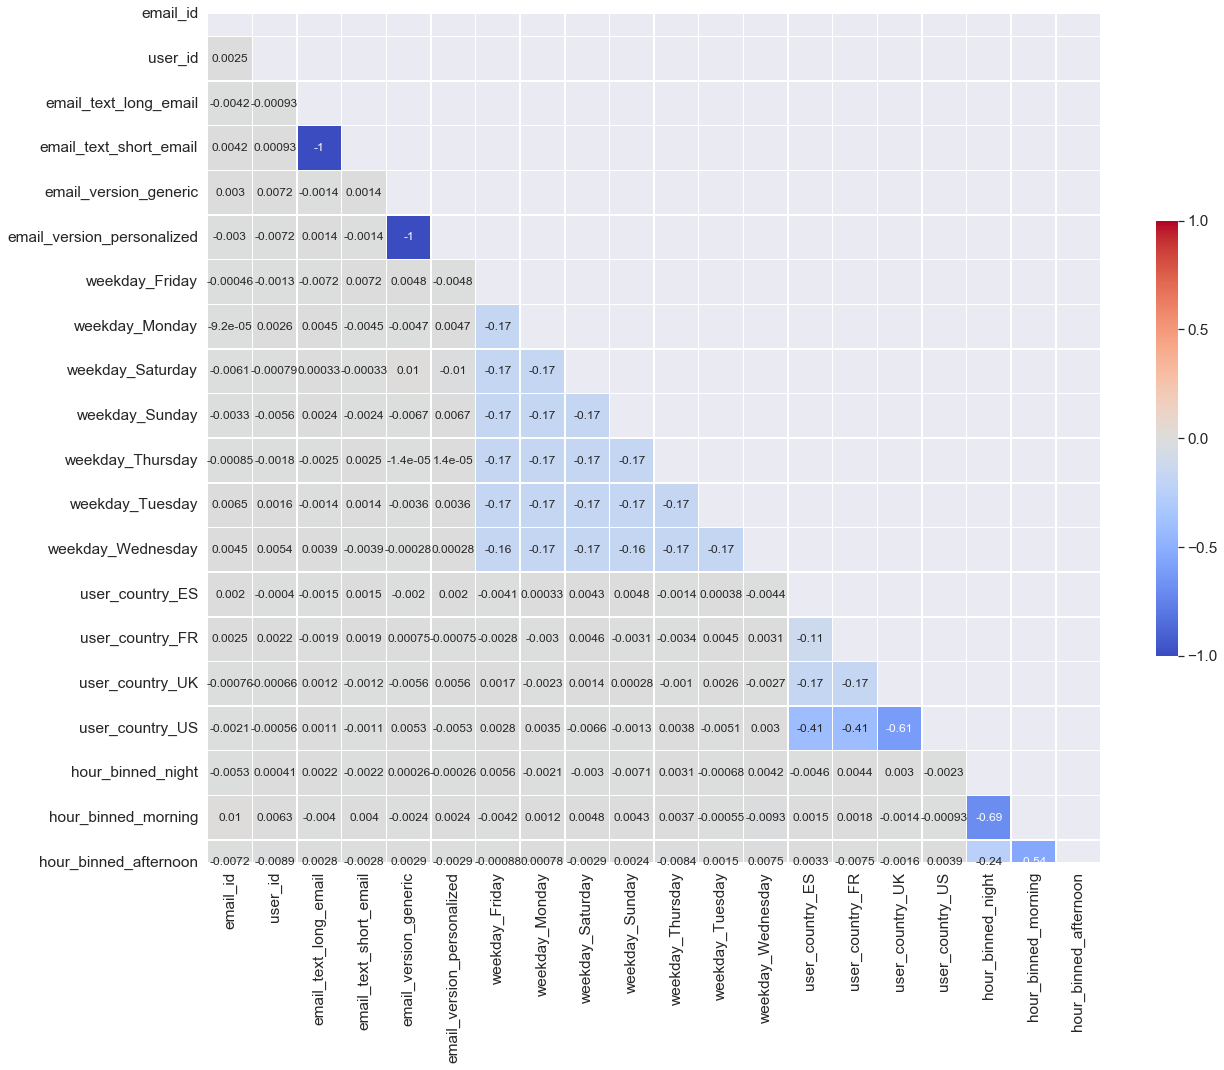

In [87]:
#Set Up Mask To Hide Upper Triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)]= True
#Create Heatmap in Seaborn
f, ax = plt.subplots(figsize=(20, 20)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#### Observations from the independent variable correlation heat map:
* Between each group of dummy variables that belong to the same independent variable:
    * There is no strong correlation between any two dummy variables that are from different parent variable. This means the **emails were sent to users with randomized email design and timing**.
        * e.g. user_country_UK and email_version_generic have no strong correlation. This means that user from UK don't have higher chance of receiving generic emails. They receive generic and personalized emails in a random way.


## 3. Analysis of how to improve the `click-through-probability` of the link inside the email



* model: logistic regression
    * Logistic regression's coefficients can help to get a basic understanding of how each variable influence the target so that we could know the priority of potential projects.



#### 3.1 Logistic regression

We will first fit an untuned logistic model to evaluate its performance. Then, we will perform cross-validation to determine the best model.

In [93]:
X_train = oversampled_trainX.copy()
y_train = oversampled_trainY.values.ravel()
y_test = y_test.values.ravel()

In [94]:
# train a logistic regression model on the training set

# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit a null model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Evaluating the null model

To evaluate the classification result,  we will utilize a confusion matrix including True Positive, True Negative, False Positive, and False Negative.
* For the training set evaluation, we can use accuracy and AUC-ROC since the data set is no longer unbalanced with the help of oversampling(SMOTE).
* For the testing set, we will use precision-recall AUC, which primarily focuses on the positive class (PPV and TPR) and gives less weight to the more frequent negative class. Since the positive class is smaller and correctly detecting positive samples (user clicks on the link) is our main focus, we should prioritize precision and recall over the accurate detection of negative samples (users not clicking on the link).




In [95]:
# Now, let's evaluate the null model using cross-validation and accuracy score

# 5-fold cross-validation with logistic regression
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
print(cv_scores)


[0.68285005 0.67770248 0.68151687 0.68322038 0.68269017]


In [96]:
# compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(cv_scores.mean()))

Average cross-validation score: 0.6816


With the null model's performance being evaluated, now let's see if we can improve the model by conducting hyperparameter optimization.

#### Hyperparameter Optimization using GridSearch CV 

Next, we will conduct a grid search cross-validation to identify the best model, using 'accuracy' as the scoring metric. This metric provides an estimate of how many of the predictions are correct.

In [99]:
# Prepare the parameters for grid search
parameters = [{'penalty':['l1','l2']}, 
              {'C':[0.001, 0.1, 1, 10, 100, 1000]}]

# instantiate the grid search model
grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

# fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'C': [0.001, 0.1, 1, 10, 100, 1000]}],
             scoring='accuracy')

In [100]:
# Examine the best model

# Best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# Print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# Print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.6817


Parameters that give the best results : 

 {'C': 0.1}


Estimator that was chosen by the search : 

 LogisticRegression(C=0.1, random_state=0, solver='liblinear')


In [110]:
model = grid_search.best_estimator_

### Evaluate the best model

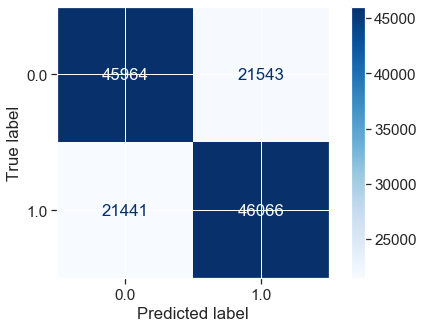

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     67507
         1.0       0.68      0.68      0.68     67507

    accuracy                           0.68    135014
   macro avg       0.68      0.68      0.68    135014
weighted avg       0.68      0.68      0.68    135014



In [127]:
# The best model's performance on the training set
y_pred = model.predict(X_train)
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_train, y_pred))

In [126]:
# Calculate predictions for the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

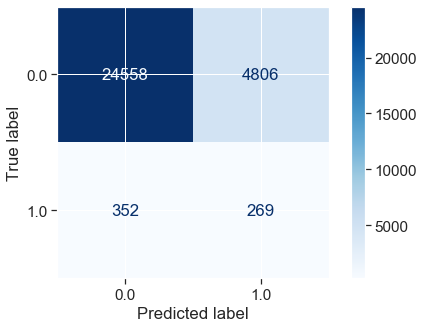

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.90     29364
         1.0       0.05      0.43      0.09       621

    accuracy                           0.83     29985
   macro avg       0.52      0.63      0.50     29985
weighted avg       0.97      0.83      0.89     29985



In [125]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, y_pred))

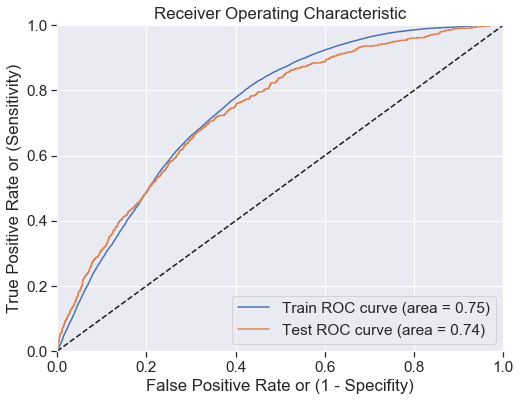

In [133]:
# Plot the ROC curve for both the training and the testing set
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)

fpr_test, tpr_test, threshold_test = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Train ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



The training set and test set have similar ROC curves. Hoever, remember that the test set is highly unbalanced, so we need to use precision-recall curve to evaluate the model's performance on the test set.

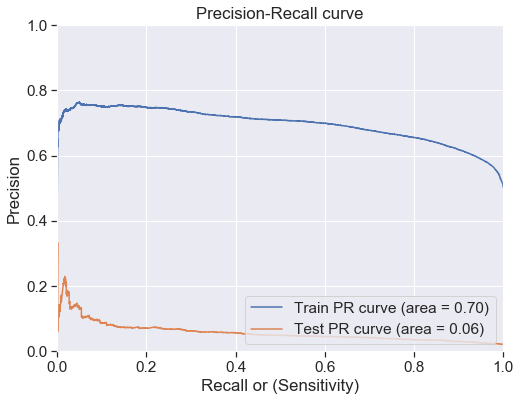

In [134]:
# Plot the Precision-Recall curve for both the training and the testing set
# Calculate the precision and recall for all thresholds of the classification
precision, recall, threshold = precision_recall_curve(y_train, model.predict_proba(X_train)[:,1])
pr_auc = auc(recall, precision)

precision_test, recall_test, threshold_test = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
pr_auc_test = auc(recall_test, precision_test)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Train PR curve (area = %0.2f)' % pr_auc)
plt.plot(recall_test, precision_test, label='Test PR curve (area = %0.2f)' % pr_auc_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall or (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()


Due to the highly unbalanced nature of our dataset, the model exhibits distinct precision-recall curves for the training and test sets. This outcome was expected as we addressed the data imbalance issue in the training set through oversampling.

Here are the performance metrics for the model:

* Training set: When the model is able to correctly identify 80% of the users who clicked on the email, out of all the users predicted to click, 65% of them actually did.
* Test set: When the model identifies 80% of the users who clicked, the majority of the predictions of users who will click are false alarms.

Overall, the model demonstrates the ability to identify users who are likely to click, although it also produces some false alarms. I believe that as the marketing campaign progresses and more users click on the link, the model will have access to a larger dataset with more features, enabling it to learn from more data points. Consequently, I anticipate that the model's performance will improve over time.

Now, let's examine the model's coefficients to gain insights from a product standpoint.

### Model coefficient analysis

In [139]:
# Sk-learn doesn't have an implementation of the logistic regression coefficients with standard errors
# Let's implement it ourselves
params = np.append(model.intercept_,model.coef_)
predictions = model.predict(X_test)

newX = X_test.copy()
newX['intercept'] = 1
MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

model_summary = pd.DataFrame()
model_summary['Variables'], model_summary["Coefficients"],model_summary["Standard Errors"],model_summary["t values"],model_summary["p-values"] = [['intercept']+list(X_train.columns),params,sd_b,ts_b,p_values]

In [140]:
model_summary

,Variables,Coefficients,Standard Errors,t values,p-values
0,intercept,-2.7257,0.008,-330.872,0.00
1,email_id,-0.2016,0.008,-24.312,0.00
2,user_id,-0.0160,0.016,-1.015,0.31
3,user_past_purchases,3.3070,0.005,690.062,0.00
4,email_text_short_email,0.2888,0.005,60.273,0.00
5,email_version_personalized,0.6284,0.009,69.917,0.00
6,weekday_Monday,0.2864,0.009,32.124,0.00
7,weekday_Saturday,0.0461,0.009,5.178,0.00
8,weekday_Sunday,-0.1402,0.009,-15.595,0.00
9,weekday_Thursday,0.4165,0.009,45.954,0.00


In [141]:
# Only keep significant variables and order results by coefficient value 

model_summary.loc[model_summary['p-values'] < 0.05].sort_values("Coefficients", ascending=False)

,Variables,Coefficients,Standard Errors,t values,p-values
3,user_past_purchases,3.3070,0.005,690.062,0.0
13,user_country_UK,0.9106,0.008,111.321,0.0
14,user_country_US,0.8699,0.006,149.776,0.0
5,email_version_personalized,0.6284,0.009,69.917,0.0
11,weekday_Wednesday,0.4924,0.011,46.067,0.0
9,weekday_Thursday,0.4165,0.009,45.954,0.0
10,weekday_Tuesday,0.3672,0.009,40.637,0.0
4,email_text_short_email,0.2888,0.005,60.273,0.0
6,weekday_Monday,0.2864,0.009,32.124,0.0
15,hour_binned_morning,0.2196,0.008,28.357,0.0


### Analyzing the output
* Categorical variables
    * Remember that when using one-hot encoding, all categorical variables are transformed into dummy variables. For a categorical variable with n levels, n-1 dummy variables are created, while the remaining level serves as the reference level. The coefficients associated with the n-1 levels are interpreted relative to this reference level. It's important to note that the sign of the coefficients (positive or negative) does not indicate absolute goodness or badness. Instead, it signifies whether a particular level is relatively better or worse than the reference level.
    * The reference levels for each categorical variable:
        * email_text:                    long_email
        * email_version:                    generic
        * weekday:                           Friday
        * user_country:                          ES
        * hour_binned:                        night
* Numerical variables:
    * One of the assumptions of Logistic Regression is that the predictors and the response exhibit a linear relationship. This assumption implies that as a predictor increases, the response should either consistently increase or decrease. However, in some cases, certain variables have a non-linear relationship with the output. For example, the variable 'hour' shows a stronger positive relationship with the clicking probability during the noon, while early morning and late night are less likely times for users to click on the link. Coefficients of non-linear variables in a Logistic Regression model can be misleading. In this case, the model may suggest that the larger the value of 'hour,' the better it is, even implying that the best time would be 24 (midnight)!
        * To address this issue, I have created indicator variables to segment the 'hour' variable into categories such as morning, afternoon, and night. This allows us to treat the non-linear variable as a categorical variable and analyze it accordingly.
* Insights
    * User country is the most influential categorical variable. Both the U.K. and the U.S. perform significantly better than Spain, while France is not as good. This discrepancy could be attributed to poor email translations that non-English-speaking users may dislike. I will coordinate with the marketing team to review the French and Spanish email templates.
    * Personalized emails outperform generic emails, indicating that sending personalized emails to every user is crucial. Furthermore, this insight has significant implications for product development. By personalizing the email subject, timing of email delivery, and other factors, we can have a more substantial impact on marketing efforts.
    * Monday to Thursday exhibit higher click-through probabilities compared to Friday, Saturday, and Sunday. Wednesday appears to be the most favorable day for sending emails. Therefore, the company should concentrate its email campaigns during the middle of the week.
    * Shorter emails seem to be better than longer emails. However, based on the coefficients, personalizing emails have higher priority than finding a general short email template that suits the majority of users. 
    * User's past purchases show a strong positive relationship with click-through probabilities. The segments created based on past purchases demonstrate similar effects on user responses. The first purchase has a very significant impact comparing to other factors. Encouraging the first purchase should be a primary focus for the marketing team. Offering promotions such as "the first one is on us" or providing coupons for initial orders can increase the chances of engagement with marketing campaigns.
    * Hour indicates that morning and afternoon slightly outperform nighttime. However, overall, the impact of timing on click-through probabilities is relatively low. This suggests that a generic timing strategy for all users may not yield optimal results. Instead, personalized timing based on users' past email interactions should be considered.
    * Surprisingly, the email_id variable is significant and negatively correlated with click-through rates. As email_id represents the sequence of email dispatch, it serves as a proxy for time. The negative coefficient suggests that as time progresses, fewer people are clicking on the email. This trend could be attributed to email service providers like Gmail labeling campaigns as spam. To mitigate this issue, it is advisable to avoid sending a large number of similar emails simultaneously. Personalizing emails and timing can help reduce the likelihood of being marked as spam.
    * The intercept term has a highly negative and significant value. It represents the model's outcome when all variables are set to their reference levels or zero values. Notably, the negative intercept is expected since most factors have a positive relationship with the outcome. For instance, when past purchases, time, and country are set to their reference levels (e.g., zero past purchases, midnight time, and Spain as the country), the chance of a user clicking is very low. It is worth mentioning that the intercept's scale is comparable to other coefficients, indicating that changing each variable's value can significantly influence the model's output. If the intercept's scale were much larger than the other coefficients, the impact of changing variables would be minimal.

### Next steps
This analysis is based on a batch of emails sent to target users as an initial step of the marketing campaign. Based on the insights gained, we should take the following actions:
* Improve the email template for non-English speaking users.
* Personalize the email content more. Brainstorm about what to include in the email from the user's activities.
* Change the email send timing according to how each user interact with the emails in the past.
* Collaborate with the marketing team to incentivize the first purchase for new users.
* Once the email content and timing have been improved and personalized, conduct an A/B test to evaluate the effectiveness of the new email sending strategy.